<a href="https://colab.research.google.com/github/arndmghsh/ImageSegmentation-StructuredSVM/blob/master/10618_HW3_1_linearSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install --upgrade ortools

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !unzip -uq "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages.zip" -d "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages"

In [0]:
# !unzip -uq "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledLabels.zip" -d "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3"

In [0]:
import os

import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms.functional as TF

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ortools.linear_solver import pywraplp

In [0]:
NUM_CLASSES = 2
NUM_FEATURES = 100

In [0]:
class VOCDataset(Dataset):
    """Class to store VOC semantic segmentation dataset"""

    def __init__(self, image_dir, label_dir, file_list):

        self.image_dir = image_dir
        self.label_dir = label_dir
        reader = open(file_list, "r")
        self.files = []
        for file in reader:
            self.files.append(file.strip())

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        # 0 stands for background, 1 for foreground
        labels = np.load(os.path.join(self.label_dir, fname+".npy"))
        labels[labels > 0.0] = 1.0
        image = Image.open(os.path.join(self.image_dir, fname+".jpg"), "r")
        sample = (TF.to_tensor(image), torch.LongTensor(labels))

        return sample

In [0]:
class AlexNet(nn.Module):
    """Class defining AlexNet layers used for the convolutional network"""

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x

In [0]:
class FCNHead(nn.Sequential):
    """Class defining FCN (fully convolutional network) layers"""

    def __init__(self, in_channels, channels):
        inter_channels = in_channels // 4
        layers = [
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(inter_channels, channels, 1)
        ]

        super(FCNHead, self).__init__(*layers)

In [0]:
class SimpleSegmentationModel(nn.Module):
    """
    Class defining end-to-end semantic segmentation model.
    It combines AlexNet and FCN layers with interpolation for deconvolution.
    This model is pretrained using cross-entropy loss.
    After pre-training, use the get_repr() function to construct 32x32x100 feature tensors for each image
    """

    def __init__(self, n_feat, n_classes):
        super(SimpleSegmentationModel, self).__init__()
        self.n_feat = n_feat
        self.backbone = AlexNet()
        self.classifier = FCNHead(256, n_feat)
        self.linear = nn.Linear(n_feat, n_classes)

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(-1, self.n_feat)
        x = self.linear(x)

        return x

    def get_repr(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = x.permute(0, 2, 3, 1)
        return x

In [0]:
class LinearSVM(nn.Module):

    def __init__(self, n_feat, n_classes):
        super(LinearSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        # TODO: Define weights for linear SVM
        # self.w = torch.autograd.Variable(torch.rand(n_feat), requires_grad=True)
        # self.b = torch.autograd.Variable(torch.rand(1), requires_grad=True)
        self.linear = nn.Linear(n_feat, n_classes)
    
    def forward(self, x):
        # TODO: Define forward function for linear SVM
        # x: 1 x 32 x 32 x 100, w: 100 , b: 1
        # y_hat = torch.dot(x,self.w)+self.b
        x = x.contiguous().view(-1, self.n_feat)
        # x: 1024 x 100
        y_hat = self.linear(x)      # returns 1024 x 2
        return y_hat

In [0]:
class StructSVM(nn.Module):

    def __init__(self, n_feat, n_classes, w, h):
        super(StructSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.w = w
        self.h = h

        # TODO: Define weights for structured SVM


    def forward(self, image):
        # TODO: Define forward function for structured SVM
        return

In [0]:
def train_cnn(model, train_batches, test_batches, num_epochs):
    """
    This function runs a training loop for the FCN semantic segmentation model
    """
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 4]))
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            # Images: torch.Size([1, 3, 32, 32]), Labels = torch.Size([1, 32, 32])
            output = model(images)
            # output: 32*32 x 2 = torch.Size([1024, 2])
            labels = labels.contiguous().view(-1, 1).squeeze()
            # labels: torch.Size([1024])
            loss = criterion(output, labels)  # inputs: torch.Size([1024, 2]) and torch.Size([1024])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            # print("Epoch: {}, itr: {}".format(epoch, i))
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_cnn(model, test_batches)

In [0]:
def test_cnn(model, test_batches):
    """
        This function evaluates the FCN semantic segmentation model on the test set
    """
    correct = 0.0
    total = 0.0
    class_gold = [0.0] * NUM_CLASSES
    class_pred = [0.0] * NUM_CLASSES
    class_correct = [0.0] * NUM_CLASSES
    for i, batch in enumerate(test_batches):
        images, labels = batch
        output = model(images)
        _, output = torch.max(output, axis=1)
        visualize_grayscale_image(output.view(32, 32).detach().numpy(), i)
        output = output.squeeze().detach().numpy()
        labels = labels.contiguous().view(-1, 1).squeeze().numpy()
        cur_class_pred = np.unique(output, return_counts=True)
        for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
            class_pred[key] += val
        cur_class_gold = np.unique(labels, return_counts=True)
        for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
            class_gold[key] += val
        cur_correct = (output == labels).tolist()
        for j, val in enumerate(cur_correct):
            if val:
                class_correct[labels[j]] += 1
        correct += np.sum(cur_correct)
        total += len(labels)
    class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
    mean_iou = sum(class_iou) / len(class_correct)
    print("Mean IOU: {}".format(mean_iou))
    print("Pixel Accuracy: {}\n".format(correct / total))

In [0]:
def train_linear_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the linear SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    criterion = nn.MultiMarginLoss(weight=torch.Tensor([1, 4]))  # Class weights to handle class imbalance
    optimizer = optim.Adam(svm_model.parameters(), lr=0.0001)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            # Images: torch.Size([1, 3, 32, 32]), Labels = torch.Size([1, 32, 32])
            fcn_output = cnn_model.get_repr(images)  # returns 1 x 32 x 32 x 100
            output = svm_model(fcn_output)       # torch.Size([1024, 2])
            labels = labels.contiguous().view(-1, 1).squeeze()   # labels: torch.Size([1024])
            loss = criterion(output, labels)    # inputs = torch.Size([1024, 2]) and torch.Size([1024])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            # print("Epoch: {}, itr: {}".format(epoch, i))
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_linear_svm(cnn_model, svm_model, test_batches)
    return

In [0]:
def test_linear_svm(cnn_model, svm_model, test_batches):
    # TODO: Write a testing function for the linear SVM
    correct = 0.0
    total = 0.0
    class_gold = [0.0] * NUM_CLASSES
    class_pred = [0.0] * NUM_CLASSES
    class_correct = [0.0] * NUM_CLASSES
    for i, batch in enumerate(test_batches):
        images, labels = batch
        fcn_output = cnn_model.get_repr(images)  # returns 1 x 32 x 32 x 100
        output = svm_model(fcn_output)       # torch.Size([1024, 2])
        _, output = torch.max(output, axis=1)
        visualize_grayscale_image(output.view(32, 32).detach().numpy(), i)
        output = output.squeeze().detach().numpy()
        labels = labels.contiguous().view(-1, 1).squeeze().numpy()

        cur_class_pred = np.unique(output, return_counts=True)
        for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
            class_pred[key] += val
        cur_class_gold = np.unique(labels, return_counts=True)
        for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
            class_gold[key] += val
        cur_correct = (output == labels).tolist()
        for j, val in enumerate(cur_correct):
            if val:
                class_correct[labels[j]] += 1
        correct += np.sum(cur_correct)
        total += len(labels)
    class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
    mean_iou = sum(class_iou) / len(class_correct)
    print("Mean IOU: {}".format(mean_iou))
    print("Pixel Accuracy: {}\n".format(correct / total))

    return

In [0]:
# TODO: Write a function to compute the structured hinge loss
# using the max-scoring output from the ILP and the gold output
# def compute_struct_svm_loss():
#     return

In [0]:
def train_struct_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the structured SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    return


def test_struct_svm(cnn_model, svm_model, test_batches):
    # TODO: Write a testing function for the structured SVM
    return

In [0]:
def visualize_grayscale_image(image, file=None):
    plt.imshow(image, cmap="gray")
    # Uncomment this to visualize image
    # plt.show()
    # Uncomment this to save image
    # plt.savefig(str(file)+".png")

Training loss after epoch 0: 0.6328337939384158
Mean IOU: 0.44546086388144446
Pixel Accuracy: 0.6883643331903945
Training loss after epoch 1: 0.6287840272991443
Mean IOU: 0.4303271701165907
Pixel Accuracy: 0.6612115405231561
Mean IOU: 0.4305581365280091
Pixel Accuracy: 0.6614745256217839


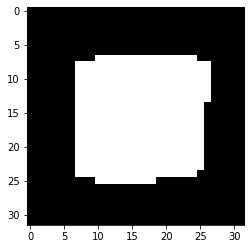

In [191]:
if __name__ == "__main__":

    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Uncomment following lines after providing appropriate paths
    path_to_image_folder = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages"
    path_to_label_folder = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledLabels"
    file_with_train_ids = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/train.txt"
    file_with_test_ids = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/test.txt"
    
    train_dataset = VOCDataset(path_to_image_folder, path_to_label_folder, file_with_train_ids)
    test_dataset = VOCDataset(path_to_image_folder, path_to_label_folder, file_with_test_ids)

    train_batches = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_batches = DataLoader(test_dataset, batch_size=1, shuffle=True)

    cnn = SimpleSegmentationModel(NUM_FEATURES, NUM_CLASSES)
    train_cnn(cnn, train_batches, test_batches, 2)
    test_cnn(cnn, test_batches)

Training loss after epoch 0: 0.6543165611350997
Mean IOU: 0.39126035364619016
Pixel Accuracy: 0.5990164022298456

Training loss after epoch 1: 0.6287558046149594
Mean IOU: 0.3921140230597239
Pixel Accuracy: 0.6004686829974271

Training loss after epoch 2: 0.6275776842760937
Mean IOU: 0.3923062454558983
Pixel Accuracy: 0.6009159251715266



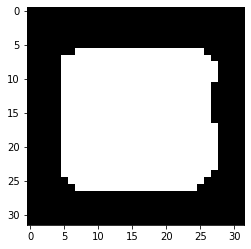

In [194]:
# TODO: Instantiate a linear SVM and call train/ test functions
linear_svm = LinearSVM(n_feat = NUM_FEATURES, n_classes = NUM_CLASSES)
train_linear_svm(cnn, linear_svm, train_batches, test_batches, num_epochs = 3)
# TODO: Instantiate a structured SVM and call train/ test functions
